# Cut based analysis 

Repeat a simple cut based analysis on Axel's and / or Rikhav's fit results. 

Plan: 
* read in the data
* Define loose cuts to get a clean photon training sample retaining 90% of the light pulses (could be optimized for best energy resolution?)
* Apply cuts to a test sample 
* Calculate the confusion matrix and $F_\beta$ for $\beta = 0.5,1,2$ to compare to ML algorithms
* Write cuts to a file s.th. they could be read in before ML and applied to light data to get a pure training set (though this feels like cheating of you are using the same data set again)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import yaml
import logging

from fastespy.readpydata import read_fit_results_manuel, read_fit_results_rikhav, read_fit_results_axel
from fastespy.readpydata import convert_data_to_ML_format
from fastespy.analysis import init_logging

from scipy.optimize import curve_fit
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import fbeta_score, precision_recall_curve, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
%matplotlib inline

In [3]:
init_logging("INFO", color=True)

#### Choose the data set and the background

This could be either `Rikhav` or `Axel`. The background is determined with the `bkg_id` variable, which is an int.

In [85]:
data_set = "Axel"
#data_set = "Rikhav"

In [86]:
if data_set == "Axel":
    fit_result = read_fit_results_axel("../../../data-04202020/Axel-Fits/")
    signal_id = 1
    feature_names = ['ampli', 'peak', 'rise', 'decay', 'chi2', 'integral']
elif data_set == 'Rikhav':
    fit_result = read_fit_results_rikhav("../../../data-04202020/Rikhav-Fits/")
    signal_id = 3
    #feature_names = ['pulse_integral_fit', 'amplitude', 'rise_time', 'decay_time', 'chi2']
    # use my integral
    feature_names = ['integral', 'amplitude', 'rise_time', 'decay_time', 'chi2']
print (fit_result.keys())

readpydata.py: 204 --- INFO: Reading file ../../../data-04202020/Axel-Fits/fits7-extrinsics-1day-50MHz-20mV-3.npy of data type 3
/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/functions.py:29: RuntimeWarning: overflow encountered in exp
  exp_decay = np.exp(decay_exp)
readpydata.py: 204 --- INFO: Reading file ../../../data-04202020/Axel-Fits/fits7-extrinsics-1day-50Mhz-20mV-2.npy of data type 2
readpydata.py: 204 --- INFO: Reading file ../../../data-04202020/Axel-Fits/fits7-lightdata-newsettings-50Mhz-5s-1.npy of data type 1
readpydata.py: 204 --- INFO: Reading file ../../../data-04202020/Axel-Fits/fits7-intrinsics-7day-50MHz-20mV.npy of data type 0


dict_keys(['ampli', 'peak', 'rise', 'decay', 'const', 'chi2', 'type', 'integral'])


In [84]:
# print obs time:
if data_set == 'Rikhav':
    for t in np.unique(fit_result['type']):
        print (t)
        m = fit_result['type'] == t
        logging.info("For type {0:n} obs time is {1:.3f}s".format(t, fit_result['tmax'][m].max() - fit_result['t0'][m].min()))
        logging.info("corresponding to {0:.3f} hr".format((fit_result['tmax'][m].max() - fit_result['t0'][m].min()) / 3600.))

<ipython-input-84-5a153614ea9c>:   6 --- INFO: For type 0 obs time is 78481.169s
<ipython-input-84-5a153614ea9c>:   7 --- INFO: corresponding to 21.800 hr
<ipython-input-84-5a153614ea9c>:   6 --- INFO: For type 1 obs time is 68302.174s
<ipython-input-84-5a153614ea9c>:   7 --- INFO: corresponding to 18.973 hr
<ipython-input-84-5a153614ea9c>:   6 --- INFO: For type 2 obs time is 202832.210s
<ipython-input-84-5a153614ea9c>:   7 --- INFO: corresponding to 56.342 hr
<ipython-input-84-5a153614ea9c>:   6 --- INFO: For type 3 obs time is 4.998s
<ipython-input-84-5a153614ea9c>:   7 --- INFO: corresponding to 0.001 hr


0
1
2
3


In [52]:
bkg_id = 2  # extrinsic day 2 for Axel's data set; does not matter what you pick here
#bkg_id = 0  # extrinsic day 2 for Rikhav's data set; does not matter what you pick here

In [53]:
X, y = convert_data_to_ML_format(fit_result, feature_names,
                                 bkg_type=bkg_id, signal_type=signal_id)

#### Split the data set into test and training sets

In [54]:
test_frac = 0.2

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=None,
                                                    test_size=test_frac
                                                    )
print (X_train.shape, X_test.shape)

m_train = y_train == 1   # signal data 

print (X_train[m_train].shape)
print (X_test[y_test == 1].shape)

(4861, 6) (1216, 6)
(3714, 6)
(898, 6)


#### Plot histograms

Histograms for the fit results for the light data set (training sample), in order to choose and optimize the cuts by eye.

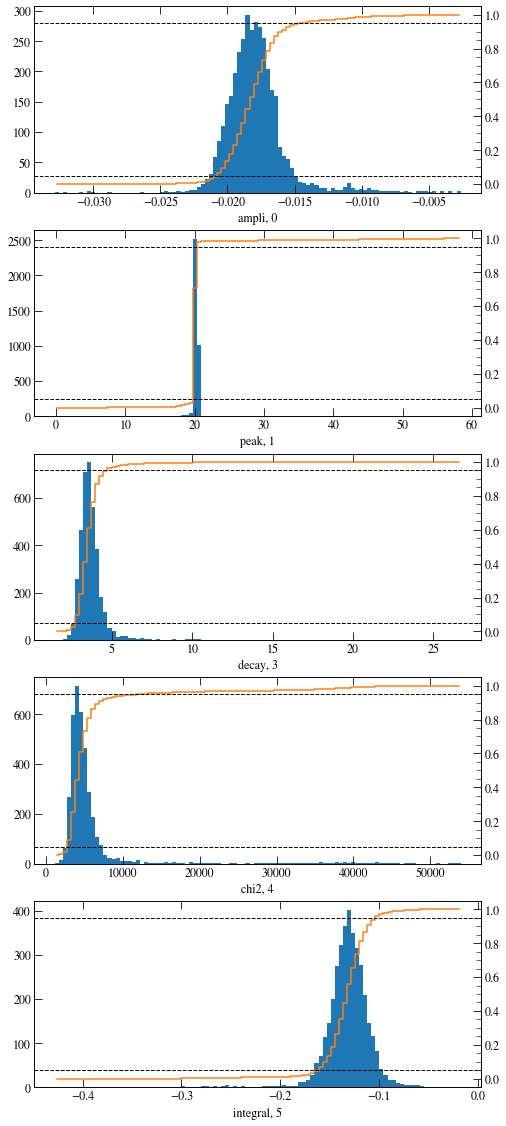

In [56]:
fig = plt.figure(figsize = (8, 4 * len(feature_names)))

iplot = 0
for i, f in enumerate(feature_names):
    
    # rise time fixed in Axel's fit
    if f == 'rise':
        continue
    
    if f == 'peak' or 'rise' in f or 'decay' in f:
        c = 1e6   # seconds to micro seconds
    else:
        c = 1.

    ax = fig.add_subplot(len(feature_names), 1, iplot+1)
    ax2 = ax.twinx()
    
    n, bins, _ = ax.hist(X_train[m_train,i] * c, bins=100)
    ax.set_xlabel("{0:s}, {1:n}".format(f, i))
    
    cdf = (np.cumsum(n) - np.cumsum(n)[0]) / (np.cumsum(n)[-1] - np.cumsum(n)[0])
    bin_center = 0.5 * (bins[1:] + bins[:-1])
    ax2.plot(bin_center, cdf,
             color=plt.cm.tab10(0.1),
             drawstyle='steps-mid'
             )
    ax2.set_yticks(np.arange(0.,1.,0.05), minor=True)
    ax2.axhline(0.05, color='k', ls='--', lw=1)
    ax2.axhline(0.95, color='k', ls='--', lw=1)
    iplot += 1

### Decide on cut parameters and replot histograms


In [57]:
if data_set == "Axel":
    cuts = {
        "chi2": "chi2 < 1e4",
        "peak" : "peak > 19.5e-6",
        "decay" : "decay < 5.e-6",
        "integral": "(integral >= -0.131 - 5*0.015) & (integral <= -0.131 + 5*0.015)", # from gaussian fit, 5 sigma interval 
    }
elif data_set == "Rikhav":
    cuts = {
        "chi2": "chi2 < 2e4",
        "rise_time" : "rise_time < 2.e-6",
        "decay_time" : "decay_time < 5.e-6",
        "integral": "(integral >= 0.131 - 5*0.015) & (integral <= 0.131 + 5*0.015)", # from gaussian fit, 5 sigma interval
    }
print (cuts)

{'chi2': 'chi2 < 1e4', 'peak': 'peak > 19.5e-6', 'decay': 'decay < 5.e-6', 'integral': '(integral >= -0.131 - 5*0.015) & (integral <= -0.131 + 5*0.015)'}


Apply the cuts:

In [58]:
def apply_cuts(cuts_dict, data, sample_mask=None):
    mask = np.ones(data.shape[0], dtype=np.bool)

    if sample_mask is None:
        sample_mask = np.ones(data.shape[0], dtype = np.bool)
    
    for c, v in cuts_dict.items():
        mask &= eval(v, {c : data[:,feature_names.index(c)]})
        logging.info("After cut on {0:s}, {1:.3f} ({2:n}) of data (events) remain".format(c, (sample_mask & mask).sum() / sample_mask.sum(),
                                                                                           (sample_mask & mask).sum()))
    
    return mask    

In [59]:
mask = apply_cuts(cuts, X_train, sample_mask=m_train)

<ipython-input-58-58931e4d23b1>:  10 --- INFO: After cut on chi2, 0.939 (3488) of data (events) remain
<ipython-input-58-58931e4d23b1>:  10 --- INFO: After cut on peak, 0.915 (3397) of data (events) remain
<ipython-input-58-58931e4d23b1>:  10 --- INFO: After cut on decay, 0.898 (3335) of data (events) remain
<ipython-input-58-58931e4d23b1>:  10 --- INFO: After cut on integral, 0.896 (3328) of data (events) remain


Re-plot the histograms and fit them with normal distributions:

ampli mean: -0.018 +/- 0.000$
ampli std: 0.001 +/- 0.000$
peak mean: 20.255 +/- 0.001$
peak std: 0.081 +/- 0.001$
decay mean: 3.529 +/- 0.010$
decay std: 0.459 +/- 0.008$
chi2 mean: 4271.766 +/- 26.634$
chi2 std: 1024.662 +/- 21.754$
integral mean: -0.131 +/- 0.000$
integral std: 0.015 +/- 0.000$


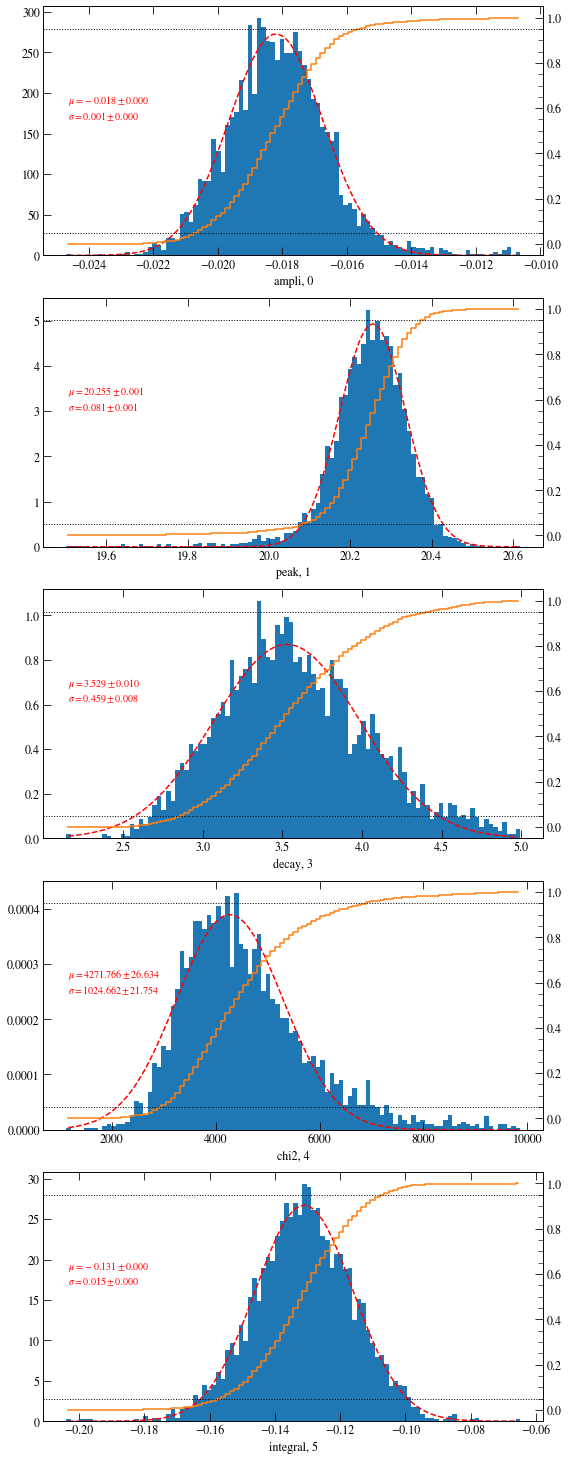

In [60]:
fig = plt.figure(figsize = (8, 4 * len(feature_names)), tight_layout=True)

mean_fit, std_fit = {}, {}
iplot = 0
for i, f in enumerate(feature_names):
    
    m = copy.deepcopy(m_train)
    m &= mask
    
    # rise time fixed in Axel's fit
    if f == 'rise':
        continue
    
    if f == 'peak' or 'rise' in f or 'decay' in f:
        c = 1e6   # seconds to micro seconds
    elif f == 'pulse_integral_fit':
        c = 1e6 * 1e3  # seconds to micro seconds, V to mV
    else:
        c = 1.

    ax = fig.add_subplot(len(feature_names), 1, iplot+1)
    
    # plot the histogram
    n, bins, _ = ax.hist(X_train[m,i] * c, bins=100, density=True)
    ax.set_xlabel("{0:s}, {1:n}".format(f, i))
    bin_center = 0.5 * (bins[1:] + bins[:-1])
    
    mean = np.mean(X_train[m,i] * c)
    std = np.sqrt(np.var(X_train[m,i] * c))
    
    # gaussian fit to the histogram
    (mean_fit[f], std_fit[f]), cov = curve_fit(norm.pdf, bin_center, n, p0=[mean, std])
    ax.plot(bin_center, norm.pdf(bin_center, mean_fit[f], std_fit[f]), 'r--')
    string = "$\mu = {0:.3f} \pm {1:.3f}$\n".format(mean_fit[f], np.sqrt(cov[0,0]))
    string += "$\sigma = {0:.3f} \pm {1:.3f}$\n".format(std_fit[f], np.sqrt(cov[1,1]))
    ax.annotate(string, xy = (0.05,0.5), xycoords='axes fraction', color='r')
    
    print ("{2:s} mean: {0:.3f} +/- {1:.3f}$".format(mean_fit[f], np.sqrt(cov[0,0]), f))
    print ("{2:s} std: {0:.3f} +/- {1:.3f}$".format(std_fit[f], np.sqrt(cov[1,1]), f))
    
    # plot the cdf on the second y axis
    ax2 = ax.twinx()
    cdf = (np.cumsum(n) - np.cumsum(n)[0]) / (np.cumsum(n)[-1] - np.cumsum(n)[0])
    ax2.plot(bin_center, cdf,
             color=plt.cm.tab10(0.1),
             drawstyle='steps-mid'
             )
    ax2.set_yticks(np.arange(0.,1.,0.05), minor=True)
    ax2.axhline(0.05, color='k', ls=':', lw=1)
    ax2.axhline(0.95, color='k', ls=':', lw=1)
    iplot += 1
    
fig.savefig(f"histograms_{data_set:s}_after_cuts.pdf")

#### Print the energy resolution:

In [61]:
if data_set == "Axel":
    eresol_features = ['integral', 'ampli']
elif data_set == "Rikhav":
    eresol_features = ['integral', 'amplitude']

for f in eresol_features:
    print ("Energy resolution from {0:s}: {1:.3f}%".format(f, np.abs(std_fit[f] / mean_fit[f]) * 100.))

Energy resolution from integral: 11.396%
Energy resolution from ampli: 8.038%


#### Save the cuts to a yaml file

In [62]:
with open("cuts_on_fits_data_set_{0:s}.yaml".format(data_set), "w") as f:
    yaml.safe_dump(cuts, f)

## Apply the cuts to the test and training data

First, re-initialize `X` and `y` in case you want to choose another background. Then apply the cuts and calculate the scores, as well as the bkg rate. 

In [76]:
bkg_id = 2  # extrinsic day 2 for Axel's data set
bkg_id = 3  # extrinsic day 3 for Axel's data set
bkg_id = 0  # intrinsic for Axel's data set

#bkg_id = 0  # extrinsic day 2 for Rikhav's data set
#bkg_id = 1  # extrinsic day 3 for Rikhav's data set
#bkg_id = 2  # intrinsic for Rikhav's data set

suffix = f"{data_set:s}_bkg_id_{bkg_id:n}"  # suffix for output files
print (suffix)

Axel_bkg_id_0


In [77]:
X, y = convert_data_to_ML_format(fit_result, feature_names,
                                 bkg_type=bkg_id, signal_type=signal_id)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=None,
                                                    test_size=test_frac
                                                    )
print (X_train.shape, X_test.shape)

m_train = y_train == 1   # signal data 

(4884, 6) (1222, 6)


#### compute the scores

In [79]:
label_name = ['train', 'test', 'all']

result = {}
for i, (X_data, y_data) in enumerate([(X_train, y_train), (X_test, y_test), (X, y)]):
    logging.info(" ===== {0} ===== ".format(label_name[i]))
    logging.info("{0:n} {1} {2}".format(i, X_data.shape, y_data.shape))
           
    m_sig = y_data == 1
    m_bkg = y_data == 0
    
    logging.info(" --- signal --- ")
    mask_sig = apply_cuts(cuts, X_data, sample_mask=m_sig)
    logging.info((mask_sig & m_sig).sum())
    
    logging.info(" --- bkg --- ")
    mask_bkg = apply_cuts(cuts, X_data, sample_mask=m_bkg)
    logging.info((mask_bkg & m_bkg).sum())
    
    logging.info(" --- all --- ")
    y_pred = apply_cuts(cuts, X_data)
    
    result[label_name[i]] = {"confusion_matrix": confusion_matrix(y_data, y_pred).tolist(),
                             "precision": float(precision_score(y_data, y_pred)),
                             "recall": float(recall_score(y_data, y_pred)),
                             "F_1": float(fbeta_score(y_data, y_pred, beta=1.)),
                             "F_{1/2}": float(fbeta_score(y_data, y_pred, beta=0.5)),
                             "F_2": float(fbeta_score(y_data, y_pred, beta=2.)),
                             "n_samples": y_data.size
                            }
    
# compute the number of predicted background events:
fp_test = np.array(result['test']['confusion_matrix'])[0,1]  # false positives for test sample
fp_test_rate = fp_test / result['test']['n_samples']  # false positive rate for test sample
bkg = fp_test_rate * (result['test']['n_samples'] + result['train']['n_samples'])  # predicted number of false positives for whole sample
result['bkg_pred'] = float(bkg)

<ipython-input-79-2a3a0ef3e924>:   5 --- INFO:  ===== train ===== 
<ipython-input-79-2a3a0ef3e924>:   6 --- INFO: 0 (4884, 6) (4884,)
<ipython-input-79-2a3a0ef3e924>:  11 --- INFO:  --- signal --- 
<ipython-input-58-58931e4d23b1>:  10 --- INFO: After cut on chi2, 0.938 (3453) of data (events) remain
<ipython-input-58-58931e4d23b1>:  10 --- INFO: After cut on peak, 0.912 (3359) of data (events) remain
<ipython-input-58-58931e4d23b1>:  10 --- INFO: After cut on decay, 0.895 (3296) of data (events) remain
<ipython-input-58-58931e4d23b1>:  10 --- INFO: After cut on integral, 0.893 (3289) of data (events) remain
<ipython-input-79-2a3a0ef3e924>:  13 --- INFO: 3289
<ipython-input-79-2a3a0ef3e924>:  15 --- INFO:  --- bkg --- 
<ipython-input-58-58931e4d23b1>:  10 --- INFO: After cut on chi2, 0.831 (999) of data (events) remain
<ipython-input-58-58931e4d23b1>:  10 --- INFO: After cut on peak, 0.608 (731) of data (events) remain
<ipython-input-58-58931e4d23b1>:  10 --- INFO: After cut on decay, 0

In [80]:
result

{'train': {'confusion_matrix': [[1202, 0], [393, 3289]],
  'precision': 1.0,
  'recall': 0.8932645301466594,
  'F_1': 0.9436235834170134,
  'F_{1/2}': 0.9766599358593658,
  'F_2': 0.9127490703224733,
  'n_samples': 4884},
 'test': {'confusion_matrix': [[292, 0], [87, 843]],
  'precision': 1.0,
  'recall': 0.9064516129032258,
  'F_1': 0.9509306260575296,
  'F_{1/2}': 0.9797768479776847,
  'F_2': 0.9237343852728468,
  'n_samples': 1222},
 'all': {'confusion_matrix': [[1494, 0], [480, 4132]],
  'precision': 1.0,
  'recall': 0.8959236773633998,
  'F_1': 0.9451052150045746,
  'F_{1/2}': 0.9772942289498581,
  'F_2': 0.9149689991142604,
  'n_samples': 6106},
 'bkg_pred': 0.0}

In [81]:
with open(f"score_results_cuts_{suffix}.yaml", "w") as f:
    yaml.safe_dump(result, f)